# Setup and Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
sns.set
import spacy
import nltk
from nltk.corpus import brown
from nltk.corpus import wordnet
from collections import Counter
import Tweet_Normalizer as tn
from bs4 import BeautifulSoup
import requests
import spacy
import scipy
import gensim
from sklearn.model_selection import train_test_split
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import csv
import math
from scipy.stats import uniform
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterSampler
import tensorflow as tf
from tensorflow import keras
import pickle
import prepare_embeddings as pe

C:\Users\ay887\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Load the Data

In [2]:
tweets = pd.read_csv("data/train.csv")

# Clean and Normalize Tweets

In [3]:
%%time
#USe tweet scrubber function to clean the data
tweets = tn.tweet_scrubber(tweets, verbose = True)

Running tweet scrubber...

Dropping unnecessary columns
Successfully dropped columns!

Normalizing the tweets
Successfully normalized tweets!

Removing invalid and mispelled words
Successfully removed invalid and mispelled words!

Successfully scrubbed tweets!

Wall time: 3min 14s


In [4]:
#Check for blank rows after cleaning. We expect 5
tweets = tweets.replace(r'^(\s)+$', np.nan, regex = True)
#Drop the empty rows
tweets.dropna(subset=["Clean Tweets"], inplace = True)
#Reset the index in place
tweets.reset_index(drop = True, inplace = True)

In [5]:
#Take a look at the last few rows of the data
pd.set_option('display.max_colwidth', 2)
tweets.tail(n=15)

,text,target,Clean Tweets
7593,Father-of-three Lost Control of Car After Overtaking and Collided #BathAndNorthEastSomerset http://t.co/fa3FcnlN86,1,father three lose control car overtake collide
7594,1.3 #Earthquake in 9Km Ssw Of Anza California #iPhone users download the Earthquake app for more information http://t.co/V3aZWOAmzK,1,earthquake km ssw california user download earthquake information
7595,Evacuation order lifted for town of Roosevelt: http://t.co/EDyfo6E2PU http://t.co/M5KxLPKFA1,1,evacuation order lift town roosevelt
7596,#breaking #LA Refugio oil spill may have been costlier bigger than projected http://t.co/5ueCmcv2Pk,1,break la oil spill may costlier big project
7597,a siren just went off and it wasn't the Forney tornado warning ??,1,siren go not tornado warning
7598,Officials say a quarantine is in place at an Alabama home over a possible Ebola case after developing symptoms... http://t.co/rqKK15uhEY,1,official say quarantine place alabama home possible ebola case develop symptom
7599,#WorldNews Fallen powerlines on G:link tram: UPDATE: FIRE crews have evacuated up to 30 passengers who were tr... http://t.co/EYSVvzA7Qm,1,fall g link tram update fire crew evacuate passenger
7600,on the flip side I'm at Walmart and there is a bomb and everyone had to evacuate so stay tuned if I blow up or not,1,flip side I bomb evacuate stay tune I blow not
7601,Suicide bomber kills 15 in Saudi security site mosque - Reuters via World - Google News - Wall ... http://t.co/nF4IculOje,1,suicide bomber kill saudi security site mosque world google news wall
7602,#stormchase Violent Record Breaking EF-5 El Reno Oklahoma Tornado Nearly Runs Over ... - http://t.co/3SICroAaNz http://t.co/I27Oa0HISp,1,violent record break el reno oklahoma tornado nearly run


# Split the Data intro Training and Validation Sets

In [6]:
train_corpus, val_corpus, y_train, y_val = train_test_split(tweets["Clean Tweets"], np.array(tweets["target"]), 
                                                  test_size=.15, random_state=42, stratify=np.array(tweets["target"]))

# Prepare Dense Word Embeddings

In [7]:
#Tokenize the training and validation set
tokenizer = ToktokTokenizer()
tokenized_train = [tokenizer.tokenize(text) for text in train_corpus]
tokenized_val = [tokenizer.tokenize(text) for text in val_corpus]

In [8]:
#Number of features to use
w2v_num_features = 300
#Create the Word2Vec model
w2v_model = gensim.models.Word2Vec(tokenized_train, vector_size=w2v_num_features,
                                   window = 250, epochs=100, min_count=0, sample=1e-3,
                                   sg=1, workers=10)
#Creat the training data
X_train = pe.document_vectorizer(corpus=tokenized_train, model=w2v_model, 
                                            num_features=w2v_num_features)

#Create the validation data
X_val = pe.document_vectorizer(corpus=tokenized_val, model=w2v_model, 
                                            num_features=w2v_num_features)

In [9]:
#Check the shapes
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(6466, 300)
(1142, 300)
(6466,)
(1142,)


# Baseline Scores

### Logistic Regression

In [13]:
lr_clf = LogisticRegression(max_iter=10000)

In [14]:
%%time
y_train_pred = cross_val_predict(lr_clf, X_train, y_train, cv = 5)
lr_base_acc = accuracy_score(y_train, y_train_pred) * 100
lr_base_f1 = f1_score(y_train, y_train_pred) * 100
print(f"Logistic Regression Baseline Accuracy: {lr_base_acc:.2f}")
print(f"Logistic Regression Baseline F1-Score: {lr_base_f1:.2f}")

Logistic Regression Baseline Accuracy: 77.75
Logistic Regression Baseline F1-Score: 72.90
Wall time: 2.96 s


In [15]:
confusion_matrix(y_train, y_train_pred)

array([[3092,  594],
       [ 845, 1935]], dtype=int64)

### Naive Bayes

In [16]:
nb_clf = GaussianNB()

In [17]:
%%time
y_train_pred = cross_val_predict(nb_clf, X_train, y_train, cv = 5)
nb_base_acc = accuracy_score(y_train, y_train_pred) * 100
nb_base_f1 = f1_score(y_train, y_train_pred) * 100
print(f"Naive Bayes Baseline Accuracy: {nb_base_acc:.2f}")
print(f"Naive Bayes Baseline F1-Score: {nb_base_f1:.2f}")

Naive Bayes Baseline Accuracy: 76.11
Naive Bayes Baseline F1-Score: 72.35
Wall time: 626 ms


In [18]:
confusion_matrix(y_train, y_train_pred)

array([[2900,  786],
       [ 759, 2021]], dtype=int64)

### Random Forest

In [19]:
rf_clf = RandomForestClassifier()

In [20]:
%%time
y_train_pred = cross_val_predict(rf_clf, X_train, y_train, cv = 5)
rf_base_acc = accuracy_score(y_train, y_train_pred) * 100
rf_base_f1 = f1_score(y_train, y_train_pred) * 100
print(f"Random Forest Baseline Accuracy: {rf_base_acc:.2f}")
print(f"Random Forest Baseline F1-Score: {rf_base_f1:.2f}")

Random Forest Baseline Accuracy: 77.73
Random Forest Baseline F1-Score: 70.97
Wall time: 51.3 s


In [21]:
confusion_matrix(y_train, y_train_pred)

array([[3266,  420],
       [1020, 1760]], dtype=int64)

### XGBoost

In [22]:
xgb_clf = xgboost.XGBClassifier(use_label_encoder=False, objective = "binary:logistic")

In [23]:
%%time
y_train_pred = cross_val_predict(xgb_clf, X_train, y_train, cv = 5)
xgb_base_acc = accuracy_score(y_train, y_train_pred) * 100
xgb_base_f1 = f1_score(y_train, y_train_pred) * 100
print(f"\nXGBoost Baseline Accuracy: {xgb_base_acc:.2f}")
print(f"XGBoost Baseline F1-Score: {xgb_base_f1:.2f}")

[21:21:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:21:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:21:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [24]:
confusion_matrix(y_train, y_train_pred)

array([[3134,  552],
       [ 903, 1877]], dtype=int64)

### Deep Learning

In [25]:
input_ = keras.layers.Input(X_train.shape[1:])
hidden1 = keras.layers.Dense(25, activation = "relu")(input_)
hidden2 = keras.layers.Dense(25, activation = "relu")(hidden1)
output = keras.layers.Dense(1, activation="sigmoid")(hidden2)
baseline_model = keras.Model(inputs=input_, outputs = output)
baseline_model.compile(loss = "binary_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [26]:
#Model architecture
print(baseline_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense (Dense)                (None, 25)                7525      
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 8,201
Trainable params: 8,201
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
%%time
early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 50, restore_best_weights=True)

history = baseline_model.fit(X_train, y_train, validation_split=.2, epochs=500, batch_size=32, verbose=0, callbacks = [early])

Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
Wall time: 18.4 s


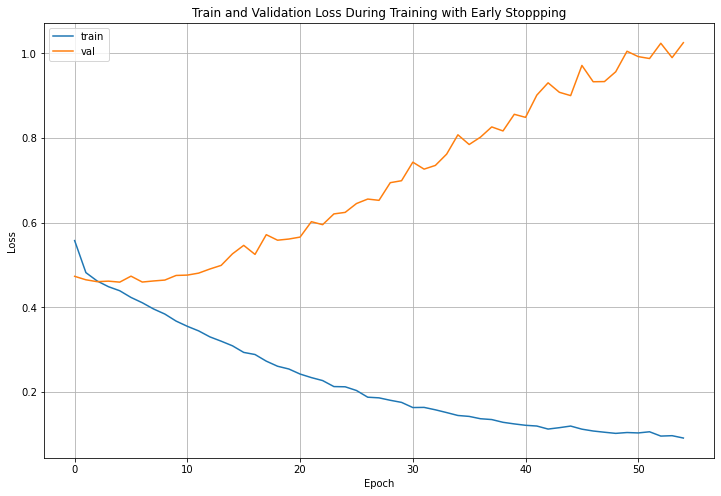

In [28]:
plt.figure(figsize = (12,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss During Training with Early Stoppping")
plt.legend()
plt.show()

In [29]:
#Baseline Accuracy and F1 Scores
y_pred = baseline_model.predict(X_val)
#Change the prediction to form expected for accuracy and f1-score functions
y_pred = np.round(y_pred.reshape((y_pred.shape[0])))
#Change the validation targets 
y_val = y_val.astype(np.int)
model_base_acc = np.round(accuracy_score(y_pred, y_val), 4) * 100
model_base_f1 = np.round(f1_score(y_pred, y_val), 4) * 100
print(f"Model Baseline Accuracy Score: {model_base_acc:.2f}%")
print(f"Model Baseline F1-Score: {model_base_f1:.2f}%")

Model Baseline Accuracy Score: 81.00%
Model Baseline F1-Score: 76.94%


In [30]:
#Confusion matrix
confusion_matrix(y_pred, y_val)

array([[563, 129],
       [ 88, 362]], dtype=int64)

# Baseline Results

In [31]:
Models = ["Logistic Regression", "Naive Bayes", "Random Forest", "XGBoost", "Deep Learning"]
F1_Base_Scores = [lr_base_f1, nb_base_f1, rf_base_f1, xgb_base_f1, model_base_f1]
Accuracy_Base_Scores = [lr_base_acc, nb_base_acc, rf_base_acc, xgb_base_acc, model_base_acc]

#Create a data frame with the results
base_results = pd.DataFrame({"Model": Models, "F1": F1_Base_Scores, "Accuracy" : Accuracy_Base_Scores})

In [32]:
base_results.sort_values(by="F1", ascending = False, inplace = True)
base_results

,Model,F1,Accuracy
4,Deep Learning,76.940000,81.000000
0,Logistic Regression,72.895084,77.745128
1,Naive Bayes,72.346519,76.105784
3,XGBoost,72.067575,77.497680
2,Random Forest,70.967742,77.729663


Text(0.5, 0, 'Models')

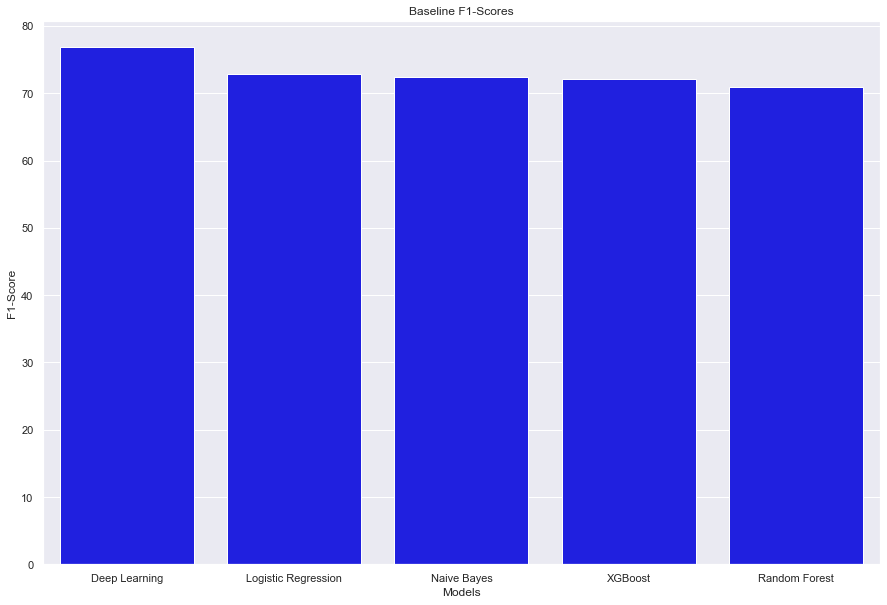

In [33]:
#Bar chart of the results
sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x="Model", y = "F1", order = base_results["Model"] \
                                            , data = base_results, color = "blue")
plt.title("Baseline F1-Scores")
plt.ylabel("F1-Score")
plt.xlabel("Models")

In [34]:
base_results.sort_values(by="Accuracy", ascending = False, inplace = True)
base_results

,Model,F1,Accuracy
4,Deep Learning,76.940000,81.000000
0,Logistic Regression,72.895084,77.745128
2,Random Forest,70.967742,77.729663
3,XGBoost,72.067575,77.497680
1,Naive Bayes,72.346519,76.105784


Text(0.5, 0, 'Models')

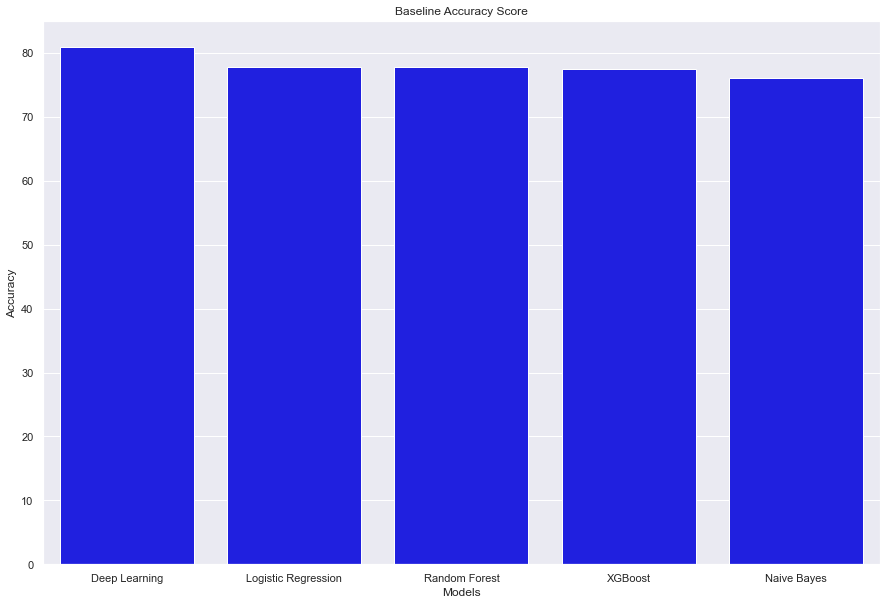

In [35]:
#Bar chart of the results
sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x="Model", y = "Accuracy", order = base_results["Model"] \
                                            , data = base_results, color = "blue")
plt.title("Baseline Accuracy Score")
plt.ylabel("Accuracy")
plt.xlabel("Models")

# Hyperparameter Tuning

### Logistic Regression

In [10]:
%%time
#Randomly search through the hyperparameter space
param_distribs = {
    "C" : np.linspace(0, 30, 10000),
    }
lr_clf = LogisticRegression(penalty = "l2", solver = "lbfgs", max_iter=10000)

lr_rnd_search_cv = RandomizedSearchCV(lr_clf, param_distribs, n_iter = 100,
                                   cv=2 ,scoring = 'f1', random_state=42, n_jobs = -1)

lr_rnd_search_cv.fit(X_train, y_train)

print(lr_rnd_search_cv.best_params_)
print(lr_rnd_search_cv.best_score_)

{'C': 2.325232523252325}
0.7181860723864846
Wall time: 1min 19s


In [11]:
#Save the results in a dataframe
lr_rnd_search_df = pd.DataFrame(lr_rnd_search_cv.cv_results_)
#Rank the results by score
lr_rnd_search_df[["param_C", "mean_test_score"]].sort_values(by = "mean_test_score", ascending = False).head()

,param_C,mean_test_score
51,2.325233,0.718186
11,2.307231,0.717948
1,2.580258,0.717919
76,2.634263,0.717443
6,1.39814,0.717257


### Random Forest

In [12]:
%%time
#Randomly search through the hyperparameter space
param_distribs = {
    "n_estimators": np.arange(50, 300)
    }
rf_clf = RandomForestClassifier()

rf_rnd_search_cv = RandomizedSearchCV(rf_clf, param_distribs, n_iter = 30,
                                   cv=2 ,scoring = 'f1', random_state=42)

rf_rnd_search_cv.fit(X_train, y_train)

print(rf_rnd_search_cv.best_params_)
print(rf_rnd_search_cv.best_score_)

{'n_estimators': 164}
0.7161347152818368
Wall time: 9min 18s


In [13]:
#Save the results
rf_rnd_search_df = pd.DataFrame(rf_rnd_search_cv.cv_results_)
tuned_params = ["param_n_estimators", "mean_test_score"]
#Rank by score
rf_rnd_search_df[tuned_params].sort_values(by = "mean_test_score", ascending = False).head()

,param_n_estimators,mean_test_score
22,164,0.716135
11,266,0.713399
15,274,0.713211
6,247,0.713087
12,286,0.712484


### XGBoost

In [14]:
#Randomly search through the hyperparameter space
param_distribs = {
    "max_depth": [2,3,4,5,6,7],
    "gamma": uniform(loc = 0.0, scale = 3),
    "min_child_weight": list(range(20,51)),
    "colsample_bytree": uniform(loc = 0.1, scale = 0.9),
    "learning_rate": uniform(loc = 0.01, scale = 0.5),
    "subsample": uniform(loc = 0.5, scale = 0.5),
    "reg_lambda": uniform(loc = 0.01, scale = 3)
    }
rng = np.random.RandomState(42)
n_iter = 100
param_list = list(ParameterSampler(param_distribs, n_iter = n_iter, random_state=rng))

In [15]:
%%time
#Create an evaluation set
eval_set = [(X_train, y_train), (X_val, y_val)]
val_f1_score = []
n_est = []
counter = 1
xgb_cf = xgboost.XGBClassifier(n_estimators = 1000, use_label_encoder=False, objective = "binary:logistic")

for params in param_list:
    xgb_cf.set_params(**params)
    xgb_cf.fit(X_train, y_train, eval_set=eval_set, eval_metric = "auc", verbose = False, early_stopping_rounds = 30)
    val_set_preds = xgb_cf.predict(X_val)
    val_f1_score.append(f1_score(y_val, val_set_preds))
    n_est.append(int(xgb_cf.get_booster().attributes()["best_ntree_limit"]))
    if counter % 10 == 0:
        print(f'Done with {counter} of {n_iter}')
    counter += 1

Done with 10 of 100
Done with 20 of 100
Done with 30 of 100
Done with 40 of 100
Done with 50 of 100
Done with 60 of 100
Done with 70 of 100
Done with 80 of 100
Done with 90 of 100
Done with 100 of 100
Wall time: 8min 52s


In [16]:
#Save the results
xgb_param_search_df = pd.DataFrame(param_list)
xgb_param_search_df["Validation F1-Score"] = val_f1_score
xgb_param_search_df["N Estimators"] = n_est
#Rank by score
xgb_param_search_df.sort_values(by="Validation F1-Score", ascending = False).head()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_lambda,subsample,Validation F1-Score,N Estimators
81,0.343862,0.399555,0.048100,7,37,1.259917,0.790581,0.765199,187
91,0.181902,2.179191,0.283723,2,43,2.741414,0.648980,0.760784,159
52,0.941153,1.914812,0.268348,6,41,2.200118,0.523858,0.759674,67
8,0.128182,2.526854,0.234877,3,49,2.789977,0.863636,0.759596,151
36,0.557933,1.908998,0.135231,7,25,2.946679,0.743371,0.759336,58


### Deep Learning

In [17]:
def build_model(n_hidden=1, n_neurons=5, lr_rate=3e-2, activation = "relu",
                drop_rate=.2, kernel = True, kernel_initializer = "he_normal", optimizer="Adam", 
                momentum = .9, nesterov = False):
    """
    This function creates a deep learning model with default parameters. This function is used to tune the hyperparameters. 
    
    returns: functional style keras model
    
    """
    input_ = keras.layers.Input(X_train.shape[1:])
    
    for layer in range(n_hidden):
        if layer == 0:
            hidden = keras.layers.Dense(n_neurons, activation = activation, kernel_initializer=kernel_initializer)(input_)
            hidden = keras.layers.Dropout(rate = drop_rate)(hidden)
                
        else:       
            hidden = keras.layers.Dense(n_neurons, activation = activation, kernel_initializer=kernel_initializer)(hidden)
            hidden = keras.layers.Dropout(rate = drop_rate)(hidden)
    
    output = keras.layers.Dense(1, activation = "sigmoid")(hidden)    
    model = keras.Model(inputs = input_, outputs = output)

    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=lr_rate, momentum=momentum, nesterov=nesterov)
    elif optimizer == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate=lr_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=lr_rate, momentum = momentum)

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ["accuracy"])

    return model

In [18]:
#Grid of hyperparameters to search through
param_distribs = {
    "n_hidden": np.arange(5, 20),
    "n_neurons": np.arange(50, 100),
    "drop_rate" : [0.20, 0.225, 0.25, 0.275, 0.30],
    "lr_rate" : [.005, .0075, 0.09, .01, 0.02, .025, .05, .075, .1 ],
    "activation": ["relu", "elu", "selu"],
    "kernel_initializer" : ["glorot_normal", "he_normal", "lecun_normal"],
    "optimizer" : ["SGD", "Adam","RMSprop"],
    "momentum" : [0.95, 0.99, 0.999, 0.9999],
    "nesterov" : [True, False]
    }

#Number of models to consider
num_models = 100
param_list = list(ParameterSampler(param_distribs, n_iter = num_models))

In [19]:
%%time

val_acc_score = []
batch = []
count = 1
early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience = 20)

for params in param_list:
    model = build_model(**params)
    batch_size = np.random.choice([32, 64])
    history = model.fit(X_train, y_train, validation_split=.2, epochs=100, batch_size=batch_size, verbose=0, callbacks = [early])
    batch.append(batch_size)
    min_val_index = np.argmax(history.history["val_accuracy"])
    min_val = history.history["val_accuracy"][min_val_index]
    val_acc_score.append(min_val)
    if count % 10 == 0:
        print(f"Done with {count} of {num_models}")
    count += 1
    

Done with 10 of 100
Done with 20 of 100
Done with 30 of 100
Done with 40 of 100
Done with 50 of 100
Done with 60 of 100
Done with 70 of 100
Done with 80 of 100
Done with 90 of 100
Done with 100 of 100
Wall time: 23min 30s


In [20]:
#Save the results in a dataframe
model_param_df = pd.DataFrame(param_list)
model_param_df["Batch Size"] = batch
model_param_df["Validation Accuracy"] = val_acc_score
#Rank the results by the validation accuracy
model_param_df.sort_values(by="Validation Accuracy", ascending = False)

,optimizer,nesterov,n_neurons,n_hidden,momentum,lr_rate,kernel_initializer,drop_rate,activation,Batch Size,Validation Accuracy
58,SGD,False,67,13,0.9500,0.0100,glorot_normal,0.225,relu,64,0.806801
59,SGD,True,75,9,0.9500,0.0200,he_normal,0.300,relu,32,0.806028
43,SGD,True,62,10,0.9500,0.0075,glorot_normal,0.300,relu,64,0.802937
84,SGD,True,62,16,0.9500,0.0100,glorot_normal,0.200,elu,64,0.799845
46,Adam,False,76,5,0.9990,0.0050,he_normal,0.225,elu,64,0.799073
...,...,...,...,...,...,...,...,...,...,...,...
33,Adam,False,99,11,0.9999,0.0250,lecun_normal,0.275,selu,64,0.566461
32,SGD,False,70,10,0.9999,0.0075,he_normal,0.300,relu,32,0.566461
31,RMSprop,False,83,17,0.9990,0.0750,he_normal,0.275,elu,32,0.566461
30,Adam,False,52,7,0.9500,0.1000,he_normal,0.225,relu,32,0.566461


# Validation Scores

### Logistic Regression

In [21]:
#Get the best hyperparameters
max_lr_f1 = lr_rnd_search_df["mean_test_score"].argmax()
best_C = lr_rnd_search_df.loc[max_lr_f1, "param_C"]

lr_clf = LogisticRegression(penalty="l2", C = best_C, random_state = 42, max_iter=10000)

In [22]:
%%time
lr_clf.fit(X_train, y_train)

Wall time: 889 ms


LogisticRegression(C=2.325232523252325, max_iter=10000, random_state=42)

In [23]:
#Validation results
y_pred = lr_clf.predict(X_val)
lr_val_f1 = np.round(f1_score(y_pred, y_val), 5) * 100
lr_val_acc = np.round(accuracy_score(y_pred, y_val), 5) * 100
print(f'Logistic Regression Validation Accuracy Score: {lr_val_acc:.2f}%')
print(f'Logistic Regression Validation F1-Score: {lr_val_f1:.2f}%')

Logistic Regression Validation Accuracy Score: 78.20%
Logistic Regression Validation F1-Score: 74.03%


In [24]:
confusion_matrix(y_pred, y_val)

array([[538, 136],
       [113, 355]], dtype=int64)

### Naive Bayes

In [25]:
nb_clf = GaussianNB()

In [26]:
%%time
nb_clf.fit(X_train, y_train)

Wall time: 75.8 ms


GaussianNB()

In [27]:
#Validation Results
y_pred = nb_clf.predict(X_val)
nb_val_f1 = np.round(f1_score(y_pred, y_val), 5) * 100
nb_val_acc = np.round(accuracy_score(y_pred, y_val), 5) * 100
print(f'Naive Bayes Validation Accuracy Score: {nb_val_acc:.2f}%')
print(f'Naive Bayes Validation F1-Score: {nb_val_f1:.2f}%')

Naive Bayes Validation Accuracy Score: 74.96%
Naive Bayes Validation F1-Score: 71.11%


In [28]:
confusion_matrix(y_pred, y_val)

array([[504, 139],
       [147, 352]], dtype=int64)

### Random Forest

In [29]:
#Get the best hyperparameters
max_rf_f1 = rf_rnd_search_df["mean_test_score"].argmax()
best_n_est = rf_rnd_search_df.loc[max_rf_f1, "param_n_estimators"]

In [30]:
rf_clf = RandomForestClassifier(n_estimators=best_n_est, random_state=42)

In [31]:
%%time
rf_clf.fit(X_train, y_train)

Wall time: 19 s


RandomForestClassifier(n_estimators=164, random_state=42)

In [32]:
#Validation Results
y_pred = rf_clf.predict(X_val)
rf_val_f1 = np.round(f1_score(y_pred, y_val), 5) * 100
rf_val_acc = np.round(accuracy_score(y_pred, y_val), 5) * 100
print(f'Random Forest Validation Accuracy Score: {rf_val_acc:.2f}%')
print(f'Random Forest Validation F1-Score: {rf_val_f1:.2f}%')

Random Forest Validation Accuracy Score: 79.07%
Random Forest Validation F1-Score: 72.31%


In [33]:
confusion_matrix(y_pred, y_val)

array([[591, 179],
       [ 60, 312]], dtype=int64)

### XGBoost

In [34]:
#Get the best hyperparameters
max_xgb_f1 = xgb_param_search_df["Validation F1-Score"].argmax()
best_colsample = xgb_param_search_df.loc[max_xgb_f1, "colsample_bytree"]
best_gamma = xgb_param_search_df.loc[max_xgb_f1, "gamma"]
best_lr = xgb_param_search_df.loc[max_xgb_f1, "learning_rate"]
best_max_depth = xgb_param_search_df.loc[max_xgb_f1, "max_depth"]
best_min_child = xgb_param_search_df.loc[max_xgb_f1, "min_child_weight"]
best_reg_lambda = xgb_param_search_df.loc[max_xgb_f1, "reg_lambda"]
best_subsample = xgb_param_search_df.loc[max_xgb_f1, "subsample"]
best_n_est = xgb_param_search_df.loc[max_xgb_f1, "N Estimators"]

xgb_clf = xgboost.XGBClassifier(n_estimators=best_n_est, colsample_bytree = best_colsample, gamma = best_gamma, 
                                learning_rate=best_lr, max_depth = best_max_depth, min_child_weight=best_min_child,
                                reg_lambda=best_reg_lambda, subsample=best_subsample,
                                use_label_encoder=False, objective = "binary:logistic")

In [35]:
%%time
xgb_clf.fit(X_train, y_train)

[10:09:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 5.84 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3438618782636169,
              enable_categorical=False, gamma=0.3995553756712491, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.048100189799581576, max_delta_step=0, max_depth=7,
              min_child_weight=37, missing=nan, monotone_constraints='()',
              n_estimators=187, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1.2599171732154375,
              scale_pos_weight=1, subsample=0.7905813105904131,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [36]:
#Validation Results
y_pred = xgb_clf.predict(X_val)
xgb_val_f1 = np.round(f1_score(y_pred, y_val), 5) * 100
xgb_val_acc = np.round(accuracy_score(y_pred, y_val), 5) * 100
print(f'XGBoost Validation Accuracy Score: {xgb_val_acc:.2f}%')
print(f'XGBoost Validation F1-Score: {xgb_val_f1:.2f}%')

XGBoost Validation Accuracy Score: 80.38%
XGBoost Validation F1-Score: 76.52%


In [37]:
confusion_matrix(y_pred, y_val)

array([[553, 126],
       [ 98, 365]], dtype=int64)

### Deep Learning

In [54]:
#Get the best hyperparameters
max_f1 = model_param_df["Validation Accuracy"].argmax()
best_n_neurons = model_param_df.loc[max_f1, "n_neurons"]
best_n_hidden = model_param_df.loc[max_f1, "n_hidden"]
best_lr_rate = model_param_df.loc[max_f1, "lr_rate"]
best_momentum = model_param_df.loc[max_f1, "momentum"]
best_init = model_param_df.loc[max_f1, "kernel_initializer"]
best_drop_rate = model_param_df.loc[max_f1, "drop_rate"]
best_act_func = model_param_df.loc[max_f1, "activation"]
best_opt = model_param_df.loc[max_f1, "optimizer"]
use_nesterov = model_param_df.loc[max_f1, "nesterov"]
best_batch_size = model_param_df.loc[max_f1, "Batch Size"]

#Initialize the model
model = build_model(n_hidden=best_n_hidden, n_neurons=best_n_neurons, lr_rate=best_lr_rate, 
                    activation = best_act_func, drop_rate=best_drop_rate, kernel = True, kernel_initializer = best_init, 
                    optimizer=best_opt, momentum = best_momentum, nesterov = False)

In [55]:
%%time
early = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 100, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split = .1, epochs = 1000, batch_size = best_batch_size, verbose = 0, callbacks=[early])

Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
Wall time: 45.8 s


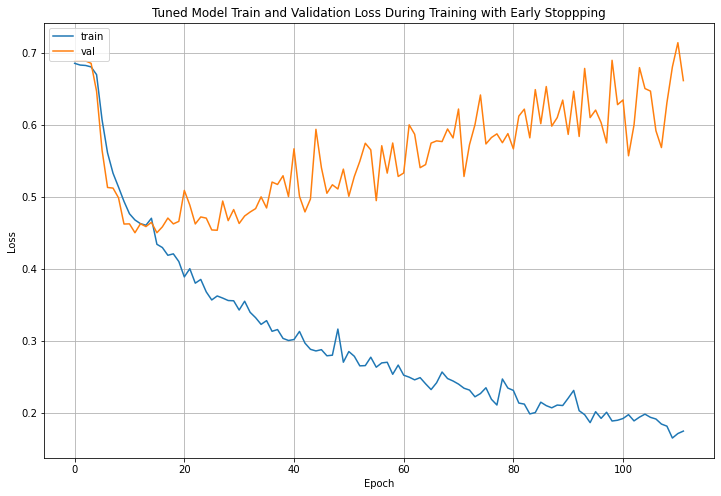

In [56]:
plt.figure(figsize = (12,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Tuned Model Train and Validation Loss During Training with Early Stoppping")
plt.legend()
plt.show()

In [57]:
# Validation Results
y_pred = model.predict(X_val)
#Change the prediction to form expected for accuracy and f1-score functions
y_pred = np.round(y_pred.reshape((y_pred.shape[0])))
#Change the validation targets 
y_val = y_val.astype(np.int)
model_val_acc = np.round(accuracy_score(y_pred, y_val), 4) * 100
model_val_f1 = np.round(f1_score(y_pred, y_val), 4) * 100
print(f"Deep Learning Validation Accuracy Score: {model_val_acc:.2f}%")
print(f"Deep Learning Validation F1-Score: {model_val_f1:.2f}%")

Deep Learning Validation Accuracy Score: 80.04%
Deep Learning Validation F1-Score: 76.30%


In [58]:
confusion_matrix(y_pred, y_val)

array([[547, 124],
       [104, 367]], dtype=int64)

# Results

### F1-Score

In [59]:
Models = ["Logistic Regression", "Naive Bayes", "Random Forest", "XGBoost", "Deep Learning"]
F1_Val_Scores = [lr_val_f1, nb_val_f1, rf_val_f1, xgb_val_f1, model_val_f1]
Accuracy_Val_Scores = [lr_val_acc, nb_val_acc, rf_val_acc, xgb_val_acc, model_val_acc]

#Create a data frame with the results
val_results = pd.DataFrame({"Model": Models, "F1": F1_Val_Scores, "Accuracy" : Accuracy_Val_Scores})

In [60]:
val_results.sort_values(by="F1", ascending = False, inplace = True)
val_results

,Model,F1,Accuracy
3,XGBoost,76.520,80.385
4,Deep Learning,76.300,80.040
0,Logistic Regression,74.035,78.196
2,Random Forest,72.306,79.072
1,Naive Bayes,71.111,74.956


Text(0.5, 0, 'Models')

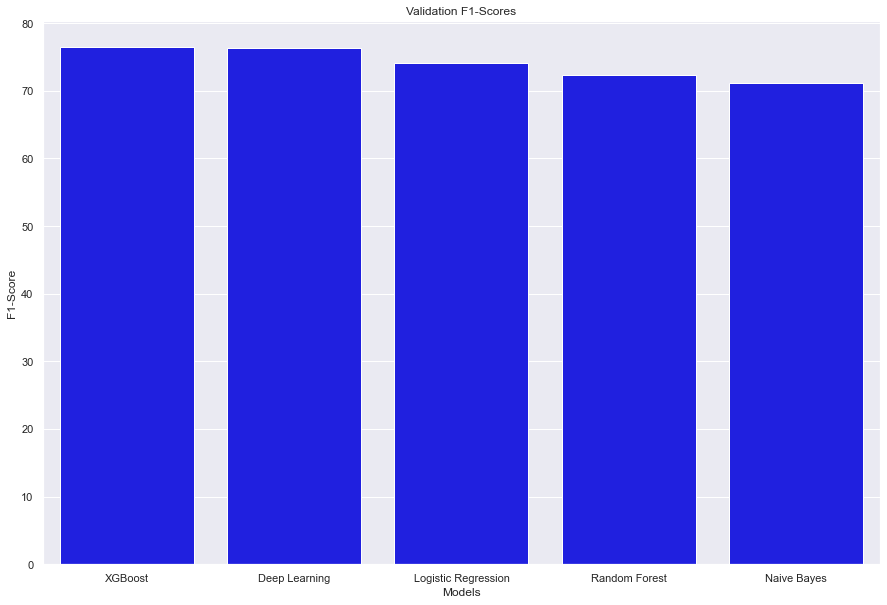

In [61]:
#Bar chart of the results
sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x="Model", y = "F1", order = val_results["Model"] \
                                            , data = val_results, color = "blue")
plt.title("Validation F1-Scores")
plt.ylabel("F1-Score")
plt.xlabel("Models")

### Accuracy

In [62]:
val_results.sort_values(by="Accuracy", ascending = False, inplace = True)
val_results

,Model,F1,Accuracy
3,XGBoost,76.520,80.385
4,Deep Learning,76.300,80.040
2,Random Forest,72.306,79.072
0,Logistic Regression,74.035,78.196
1,Naive Bayes,71.111,74.956


Text(0.5, 0, 'Models')

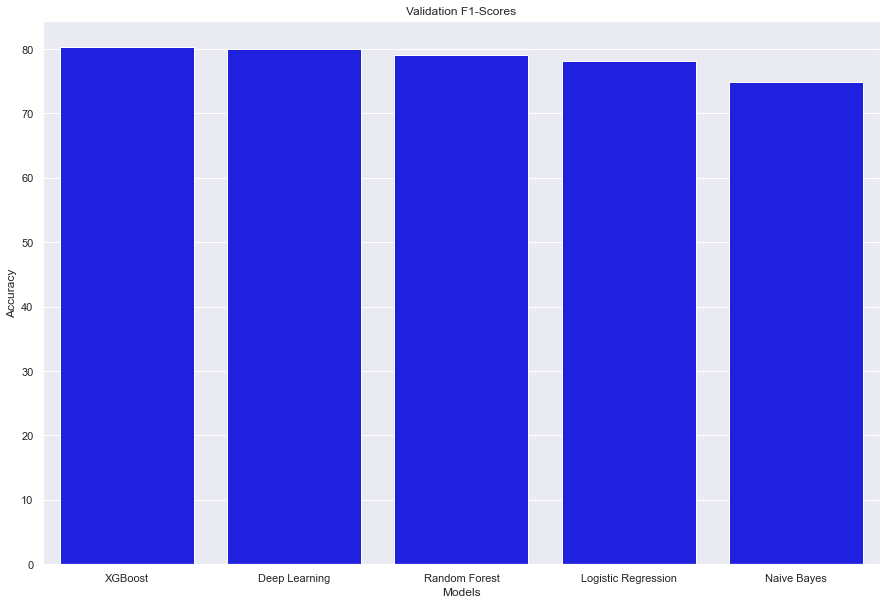

In [63]:
#Bar chart of the results
sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x="Model", y = "Accuracy", order = val_results["Model"] \
                                            , data = val_results, color = "blue")
plt.title("Validation F1-Scores")
plt.ylabel("Accuracy")
plt.xlabel("Models")

# Save the Best Model

### Create the dense embedding with all the training tweets

In [64]:
tokenized_corpus = [tokenizer.tokenize(text) for text in tweets["Clean Tweets"]]

#Number of features to use
w2v_num_features = 300
#Create the Word2Vec model
w2v_model = gensim.models.Word2Vec(tokenized_corpus, vector_size=w2v_num_features,
                                   window = 250, epochs=100, min_count=0, sample=1e-3,
                                   sg=1, workers=10)
#Creat the training data
X = pe.document_vectorizer(corpus=tokenized_corpus, model=w2v_model, 
                                            num_features=w2v_num_features)

y = tweets["target"]

In [65]:
#Check the shape
print(X.shape)
print(y.shape)

(7608, 300)
(7608,)


In [66]:
#Reinitialize XGBoost model
xgb_clf = xgboost.XGBClassifier(n_estimators=best_n_est, colsample_bytree = best_colsample, gamma = best_gamma, 
                                learning_rate=best_lr, max_depth = best_max_depth, min_child_weight=best_min_child,
                                reg_lambda=best_reg_lambda, subsample=best_subsample,
                                use_label_encoder=False, objective = "binary:logistic")

In [67]:
%%time
#Fit on all training instances
xgb_clf.fit(X, y)

[10:28:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 7.42 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3438618782636169,
              enable_categorical=False, gamma=0.3995553756712491, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.048100189799581576, max_delta_step=0, max_depth=7,
              min_child_weight=37, missing=nan, monotone_constraints='()',
              n_estimators=187, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1.2599171732154375,
              scale_pos_weight=1, subsample=0.7905813105904131,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [68]:
#Save the model
pickle.dump(xgb_clf, open("best_w2v_model.sav",'wb'))